In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the data
df = pd.read_csv("Load_demand_data.csv")
# Check the first few rows
print(df.head())


# Reshape the data as before to long format
df_long = df.melt(id_vars=['zone_id', 'year', 'month', 'day'], # These are the fixed columns
                  value_vars=[f'h{i}' for i in range(1, 25)], # These are the hourly columns
                  var_name='hour', value_name='value') # Rename the hour and value columns


df_long['hour'] = df_long['hour'].str.extract('(\d+)').astype(int) # Extract the numeric hour from the 'hour' column

df_long['datetime'] = pd.to_datetime(df_long[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)) \
    + pd.to_timedelta(df_long['hour'] - 1, unit='h') # Create datetime column (combine year, month, day, and hour)

df_long = df_long.drop(columns=['year', 'month', 'day', 'hour']) # Drop the year, month, day, and hour columns since we now have datetime and value

df_long = df_long[['zone_id', 'datetime', 'value']] # Reorder the columns to have zone_id, datetime, and value

df_long = df_long.sort_values(by=['zone_id', 'datetime']).reset_index(drop=True) # Sort the dataframe by datetime to ensure continuous time order


print(df_long.head()) # To check if the data is cleaned


# Convert the 'value' column to numeric, handling commas
df_long['value'] = df_long['value'].str.replace(',', '', regex=True).astype(float)

# Scaling the values to the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
df_long['value'] = scaler.fit_transform(df_long[['value']])

# Check if the data is scaled
print(df_long.head())

   zone_id  year  month  day      h1      h2      h3      h4      h5      h6  \
0        1  2004      1    1  16,853  16,450  16,517  16,873  17,064  17,727   
1        1  2004      1    2  14,155  14,038  14,019  14,489  14,920  16,072   
2        1  2004      1    3  14,439  14,272  14,109  14,081  14,775  15,491   
3        1  2004      1    4  11,273  10,415   9,943   9,859   9,881  10,248   
4        1  2004      1    5  10,750  10,321  10,107  10,065  10,419  12,101   

   ...     h15     h16     h17     h18     h19     h20     h21     h22  \
0  ...  13,518  13,138  14,130  16,809  18,150  18,235  17,925  16,904   
1  ...  16,127  15,448  15,839  17,727  18,895  18,650  18,443  17,580   
2  ...  13,507  13,414  13,826  15,825  16,996  16,394  15,406  14,278   
3  ...  14,207  13,614  14,162  16,237  17,430  17,218  16,633  15,238   
4  ...  13,845  14,350  15,501  17,307  18,786  19,089  19,192  18,416   

      h23     h24  
0  16,162  14,750  
1  16,467  15,258  
2  13,315  12,

Training data shape: torch.Size([608195, 24, 1])
Test data shape: torch.Size([152049, 24, 1])


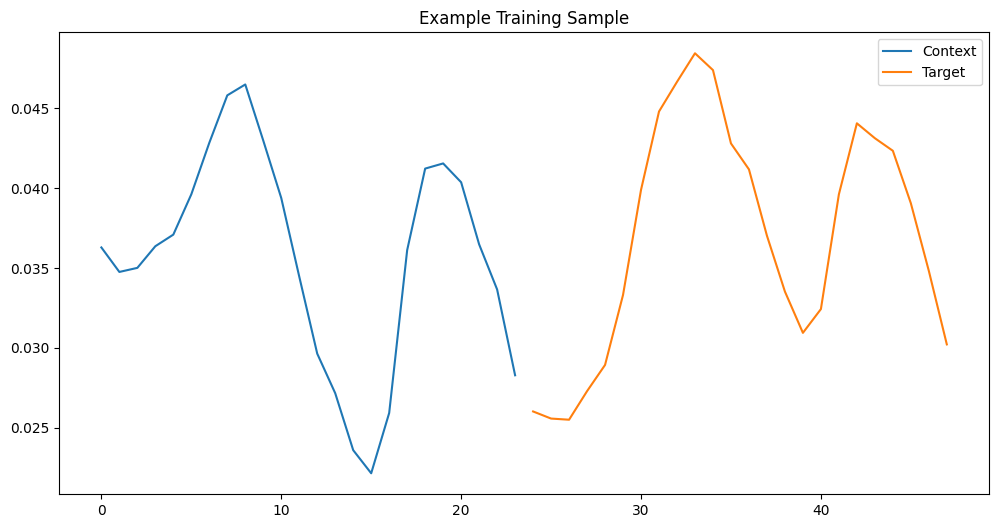

In [ ]:
df_long['value_normalized'] = df_long.groupby('zone_id')['value'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel()
)

# Create sequences for time series forecasting
def create_sequences(data, sequence_length, target_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - target_length + 1):
        x = data[i:(i + sequence_length)]
        y = data[(i + sequence_length):(i + sequence_length + target_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence and target lengths
sequence_length = 24  # Use 24 hours (1 day) as input sequence
target_length = 24    # Predict the next 24 hours (1 day)

# Prepare data for each zone_id
zone_ids = df_long['zone_id'].unique()
X_all, y_all = [], []

for zone_id in zone_ids:
    zone_data = df_long[df_long['zone_id'] == zone_id]['value_normalized'].values
    X, y = create_sequences(zone_data, sequence_length, target_length)
    X_all.append(X)
    y_all.append(y)

# Concatenate data from all zones
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape X_train and X_test to match the expected input shape for models
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)    # Add feature dimension

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Verify your data
print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, context_length, 1)
print(f"Test data shape: {X_test.shape}")

context_length = sequence_length  # or 24, if you prefer hardcoding
pred_length = target_length       # or 24, similarly

# Plot example sample
plt.figure(figsize=(12, 6))
plt.plot(X_train[0].numpy(), label='Context')
plt.plot(range(context_length, context_length+pred_length),
         y_train[0].numpy(), label='Target')
plt.legend()
plt.title("Example Training Sample")
plt.show()

In [ ]:
## Base Transformer Components --------------------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class TransformerBase(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])

## Model Implementations --------------------------------------------------------

class NonstationaryTransformer(TransformerBase):
    """Nonstationary Transformer with adaptive normalization"""
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__(input_dim, output_dim, pred_length, embed_dim, num_layers, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.adapt_norm = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = self.norm(x)

        for i, layer in enumerate(self.transformer.layers):
            x = layer(x)
            x = self.adapt_norm[i](x)

        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])

In [ ]:
## Trainer Class -------------------------------------------------------------

class Trainer:
    def __init__(self, model, pred_length, loss_process='ERM', constraint_level=None):
        self.model = model
        self.pred_length = pred_length
        self.loss_process = loss_process

        if loss_process in ['Constant', 'Exponential']:
            self.dual_vars = nn.Parameter(torch.ones(pred_length), requires_grad=True)
            self.slack_vars = nn.Parameter(torch.zeros(pred_length), requires_grad=True)
            self.constraint_level = constraint_level

    def compute_losses(self, x, y_true):
        y_pred = self.model(x)
        step_losses = torch.mean((y_pred - y_true)**2, dim=(0, 2))  # MSE per time step
        return step_losses

    def train_step(self, x, y_true, epsilon=None, primal_optim=None, dual_optim=None, slack_optim=None):
        if self.loss_process == 'ERM':
            # Standard ERM training
            primal_optim.zero_grad()
            y_pred = self.model(x)
            loss = torch.mean((y_pred - y_true)**2)
            loss.backward()
            primal_optim.step()
            return torch.mean((y_pred - y_true)**2, dim=(0, 2)).detach().cpu().numpy()

        else:
            # Constrained learning
            primal_optim.zero_grad()
            dual_optim.zero_grad()
            slack_optim.zero_grad()

            step_losses = self.compute_losses(x, y_true)

            # Compute Lagrangian
            lagrangian = torch.sum((self.dual_vars + 1/self.pred_length) * step_losses) - \
                        torch.sum(self.dual_vars * (epsilon + self.slack_vars)) + \
                        0.5 * torch.sum(self.slack_vars**2)

            lagrangian.backward()

            # Update parameters
            primal_optim.step()

            # Update dual variables (projected gradient ascent)
            with torch.no_grad():
                constraint_violation = step_losses - (epsilon + self.slack_vars)
                self.dual_vars.data = torch.clamp(self.dual_vars + 0.01 * constraint_violation, min=0)

                # Update slack variables
                slack_grad = self.slack_vars.grad - self.dual_vars
                self.slack_vars.data = torch.clamp(self.slack_vars - 0.001 * slack_grad, min=0)

            return step_losses.detach().cpu().numpy()

    def train(self, train_loader, val_loader, epochs=10):
        # Initialize optimizers
        primal_optim = optim.Adam(self.model.parameters(), lr=1e-3)

        if self.loss_process != 'ERM':
            dual_optim = optim.SGD([self.dual_vars], lr=0.01)
            slack_optim = optim.SGD([self.slack_vars], lr=0.001)

            # Set epsilon based on constraint type
            if self.constraint_level is None:
                erm_losses = self._get_erm_losses(train_loader)
                erm_losses = torch.tensor(erm_losses)
                if self.loss_process == 'Constant':
                    epsilon = torch.ones(self.pred_length) * torch.median(erm_losses)
                elif self.loss_process == 'Exponential':
                    epsilon = torch.linspace(erm_losses.min(), erm_losses.max(), self.pred_length)
            else:
                epsilon = self.constraint_level
        else:
            dual_optim = None
            slack_optim = None
            epsilon = None

        train_loss_history = []
        val_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Training {self.model.__class__.__name__} with {self.loss_process}"):
            self.model.train()
            epoch_train_losses = []

            for x, y in train_loader:
                step_losses = self.train_step(x, y, epsilon, primal_optim, dual_optim, slack_optim)
                epoch_train_losses.append(step_losses)

            # Average losses across batches
            avg_train_loss = np.mean(epoch_train_losses, axis=0)
            train_loss_history.append(avg_train_loss)

            # Validation
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for x, y in val_loader:
                    val_loss = self.compute_losses(x, y).cpu().numpy()
                    val_losses.append(val_loss)

            avg_val_loss = np.mean(val_losses, axis=0)
            val_loss_history.append(avg_val_loss)

        return train_loss_history, val_loss_history

    def _get_erm_losses(self, loader):
        """Get baseline losses from ERM model"""
        temp_model = type(self.model)(self.model.embedding.in_features,
                                    self.model.fc_out.out_features,
                                    self.pred_length)
        optimizer = optim.Adam(temp_model.parameters())

        losses = []
        for x, y in loader:
            optimizer.zero_grad()
            y_pred = temp_model(x)
            # Calculate the total loss for the batch before calculating the mean per time step
            loss = torch.mean((y_pred - y)**2)
            loss.backward()
            optimizer.step()
            # Calculate the mean loss per time step after the backward pass
            step_losses = torch.mean((y_pred - y)**2, dim=(0, 2))
            losses.append(step_losses.detach().cpu().numpy())

        return np.mean(losses, axis=0)

In [ ]:
class TransformerBase(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, pred_length=96):
        super(TransformerBase, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pred_length = pred_length

        # Transformer architecture
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.transpose(0, 1)  # Change shape for transformer input
        x = self.transformer_encoder(x)
        x = x[-1, :, :]  # Get the last output
        x = self.fc(x)
        return x

class NonstationaryTransformer(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, pred_length=96):
        super(NonstationaryTransformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pred_length = pred_length

        # Nonstationary transformer components
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.transpose(0, 1)  # Change shape for transformer input
        x = self.transformer_encoder(x)
        x = x[-1, :, :]  # Get the last output
        x = self.fc(x)
        return x


# Data Preparation and Experiment Code

def prepare_data(data, context_length, pred_length):
    """Create sequences for time series forecasting"""
    sequences = []
    targets = []
    for i in range(len(data) - context_length - pred_length + 1):
        sequences.append(data[i:i+context_length])
        targets.append(data[i+context_length:i+context_length+pred_length])
    return np.array(sequences), np.array(targets)

def run_experiment(models, loss_processes, data, context_length, pred_length, epochs=10):
    # Prepare data
    X, y = prepare_data(data, context_length, pred_length)

    # Split into train and validation
    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)

    # Create dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    results = {}

    for model_class in models:
        for process in loss_processes:
            # Initialize model and trainer
            model = model_class(input_dim=1, output_dim=1, pred_length=pred_length)
            trainer = Trainer(model, pred_length, loss_process=process)

            # Train
            train_loss, val_loss = trainer.train(train_loader, val_loader, epochs=epochs)

            # Store results
            key = f"{model_class.__name__}_{process}"
            results[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'final_step_loss': val_loss[-1]  # Final validation step losses
            }

    return results

def plot_results(results, pred_length):
    """Plot the step-wise losses for all models and processes"""
    plt.figure(figsize=(15, 10))

    for i, (key, result) in enumerate(results.items()):
        model_name, process = key.split('_')
        plt.subplot(3, 3, i+1)
        plt.plot(result['final_step_loss'], label=process)
        plt.title(f"{model_name} - {process}")
        plt.xlabel('Time Step')
        plt.ylabel('MSE')
        plt.legend()
        plt.ylim(0, np.max(result['final_step_loss']) * 1.2)

    plt.tight_layout()
    plt.show()

def print_last_mse(results):
    """Print the last MSE value for all models and loss processes"""
    for key, result in results.items():
        model_name, process = key.split('_')
        print(f"{model_name} - {process}: Last MSE = {result['final_step_loss'][-1]}")

# Main Execution
def main():
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate synthetic time series data
    time = np.arange(0, 1000, 0.1)
    data = np.sin(time) + 0.1 * np.random.randn(len(time))
    data = data.reshape(-1, 1)  # (n_samples, n_features)

    # Experiment parameters
    context_length = 96
    pred_length = 96
    epochs = 20

    # Models to test
    models = [TransformerBase, NonstationaryTransformer]
    loss_processes = ['ERM', 'Constant', 'Exponential']

    # Run experiment
    results = run_experiment(models, loss_processes, data, context_length, pred_length, epochs)

    # Plot results
    plot_results(results, pred_length)

    # Print last MSE values for all models and loss processes
    print_last_mse(results)

if __name__ == "__main__":
    main()
